# Wisconsin Diagnostic Breast Cancer

569 instances with breast cancer dignosis (212 malignant, 357 benign) and 30 predictor variables.

See also original [UCI source](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

This dataset contains only continuous numeric data and has no missing values.
It allows for very good prediction results without further feature engineering.
Hence, is a good dataset for comparing different binary classification models.

In [1]:
from time import time
import numpy as np
import pandas as pd
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = datasets.load_breast_cancer()
#print(data['DESCR'])

X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'], name='target')
display(X.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Split training and test data

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("train: ", X_train.shape, ', test:', X_test.shape)

train:  (398, 30) , test: (171, 30)


# Model Training

Train and evaluate following models

* Logistic Regression
* Multi-layer Perceptron
* XGBoost

**Helper functions for visualizing model results:**

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report

def show_results(y_true, y_hat, labels, title=None, threshold=0.5, youden=True, report=True):
    
    fig, axs = plt.subplots(2,2, figsize=(8,6))
    axs = axs.ravel()
    
    fpr, tpr, thres = roc_curve(y_test, y_hat)
    if youden:
        threshold = thres[np.where(tpr-fpr == max(tpr-fpr))][0]
    
    # histogram of predicted probabilities
    names = [labels[i] for i in [1,0]]
    axs[0].hist([y_hat[y_true==1], y_hat[y_true==0]], stacked=True, label=names, bins=25)
    axs[0].axvline(x=0.5, color='grey', linestyle='--')
    if youden:
        axs[0].axvline(x=threshold, color='r', linestyle='--', label=f'Youden: {threshold:.3f}')
    axs[0].set_title('Predicted Probabilities')
    axs[0].legend(loc='upper center')
    
    # roc curve
    axs[1].plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    axs[1].plot([0, 1], [0, 1], 'k--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('FPR')
    axs[1].set_ylabel('TPR')
    axs[1].set_title('ROC (AUC=%0.3f)' % auc(fpr, tpr))
    
    # roc thresholds
    axs[3].plot(thres[1:], 'o--')
    axs[3].set_title('ROC Thresholds')
    
    # confusion_matrix
    cf = pd.crosstab(y_true, y_hat >= threshold, rownames=['Predicted'], colnames=['Actual']).astype(int)
    text=['', '(False Alarm)', '(Miss)', '']
    text=pd.DataFrame(np.asarray(["{0}\n{1}".format(text,data) for text, data in zip(cf.values.flatten(), text)]).reshape(2,2))
    sns.heatmap(cf, cmap='Blues', annot=text, ax=axs[2], cbar=False, fmt='s')
    axs[2].set_title(f'Confusion Matrix (threshold={threshold:.2f})')
    axs[2].set_xticklabels(labels)
    axs[2].set_yticklabels(labels, va='center')
    axs[2].tick_params(axis='both', which='major', left=False, bottom=False)
    
    
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    
    if report:
        print(classification_report(y_test, y_hat >= threshold))

## Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

   micro avg       0.98      0.98      0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



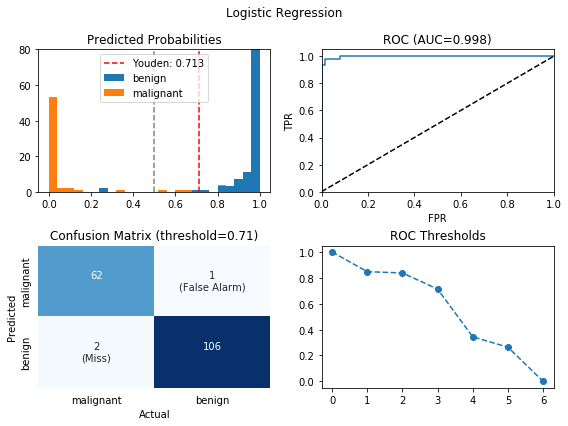

In [5]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)
y_hat = clf.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], title="Logistic Regression")

In [6]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

   micro avg       0.98      0.98      0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



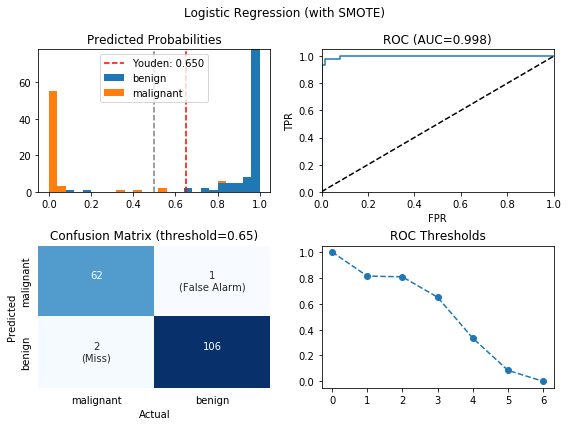

In [7]:
lr_ppl = ImbPipeline(steps = [('smote', SMOTE()), ('clf', LogisticRegression(solver='liblinear'))])
lr_ppl.fit(X_train, y_train)
y_hat = lr_ppl.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], title="Logistic Regression (with SMOTE)")

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        63
           1       0.97      0.99      0.98       108

   micro avg       0.98      0.98      0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



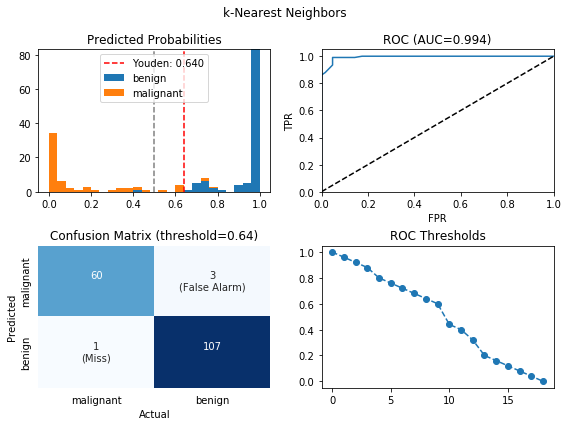

In [8]:
#clf = LogisticRegressionCV(solver='liblinear', Cs=[0.01, 0.1, 1.0, 10], cv=10, verbose=1, max_iter=1000, class_weight=None, scoring='roc_auc')

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=25)

clf.fit(X_train, y_train)
y_hat = clf.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], title="k-Nearest Neighbors")

## Multi-layer Perceptron

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

ppl_mlp = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('mlp', MLPClassifier(max_iter=2000))
])

-> took 2.2 seconds


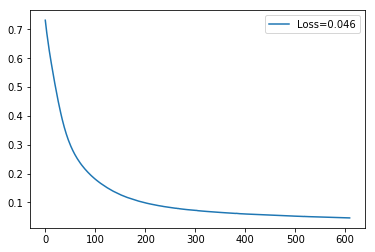

In [10]:
start = time()
ppl_mlp.fit(X_train, y_train)
print('-> took %.1f seconds' % (time() - start))

def show_loss(clf):
    plt.plot(clf.loss_curve_, label=f"Loss={clf.loss_:0.3f}")
    plt.legend()

show_loss(ppl_mlp.named_steps['mlp'])

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

   micro avg       0.98      0.98      0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



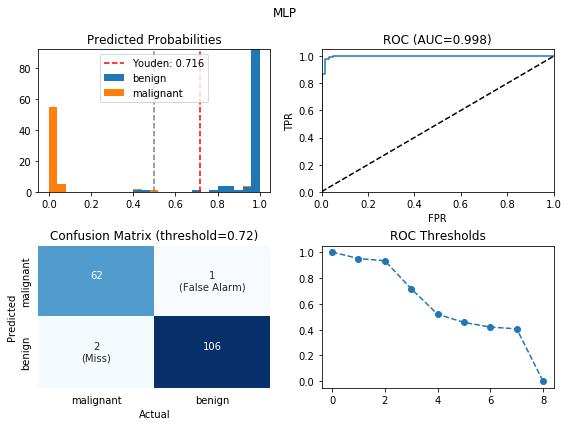

In [11]:
y_hat = ppl_mlp.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], title="MLP")

In [12]:
from sklearn.model_selection import GridSearchCV

params = {
    'mlp__hidden_layer_sizes': [ (32), (16), (32, 16) ],
    'mlp__alpha': [ 1e-5, 1e-6 ],
    'mlp__activation': ["logistic", "relu"],
    'mlp__solver' : ['adam'] # sgd is faster but adam is better
}

gs = GridSearchCV(
    estimator=ppl_mlp,
    param_grid=params,
    n_jobs=4,
    cv=10,
    scoring="roc_auc", # neg_log_loss, f1, average_precision, balanced_accuracy
    return_train_score=True,
    iid=False,
    refit=True,
    verbose=1)

start = time()
gs.fit(X_train, y_train)
print('-> took %.1f seconds' % (time() - start))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   55.6s finished


-> took 56.5 seconds


In [13]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
2,1.702586,0.137286,0.003089,0.000361,logistic,1e-05,"(32, 16)",adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",1.0,...,0.999200,0.996002,0.996002,0.995436,0.996069,0.997035,0.997268,0.996609,0.996553,0.001034
5,2.282450,0.201101,0.003979,0.000552,logistic,1e-06,"(32, 16)",adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",1.0,...,0.999167,0.995836,0.996169,0.996269,0.996035,0.996902,0.997368,0.996576,0.996633,0.000958
0,1.592611,0.161063,0.003902,0.002097,logistic,1e-05,32,adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",1.0,...,0.998701,0.995469,0.995602,0.995569,0.996135,0.996968,0.996602,0.995621,0.996211,0.000954
3,2.251698,0.289269,0.005234,0.002409,logistic,1e-06,32,adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",1.0,...,0.998434,0.995536,0.995536,0.995769,0.996102,0.997168,0.996702,0.995984,0.996243,0.000898
4,1.951916,0.202064,0.003755,0.000509,logistic,1e-06,16,adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",1.0,...,0.998368,0.995236,0.995203,0.995869,0.995836,0.997268,0.996369,0.995358,0.996051,0.000977


{'mlp__activation': 'logistic', 'mlp__alpha': 1e-05, 'mlp__hidden_layer_sizes': (32, 16), 'mlp__solver': 'adam'}


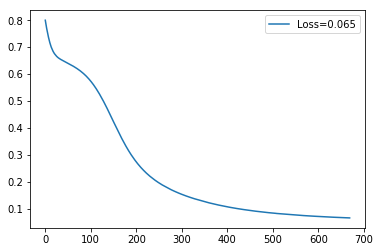

In [14]:
print(gs.best_params_)
gs.best_estimator_.fit(X_train, y_train);
clf = gs.best_estimator_.named_steps['mlp']

show_loss(gs.best_estimator_.named_steps['mlp'])

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.99      1.00      1.00       108

   micro avg       0.99      0.99      0.99       171
   macro avg       1.00      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



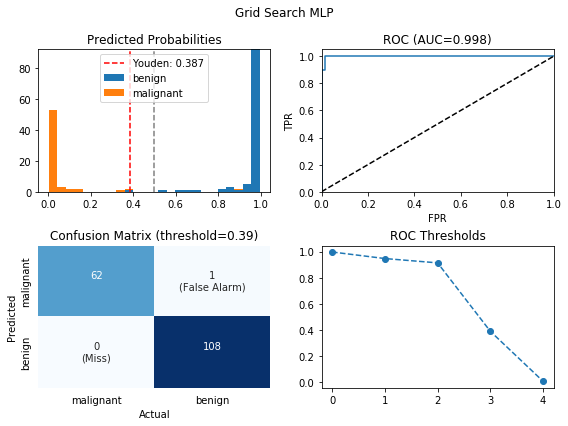

In [15]:
y_hat = gs.best_estimator_.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], 'Grid Search MLP')

## XGBoost

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

   micro avg       0.98      0.98      0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



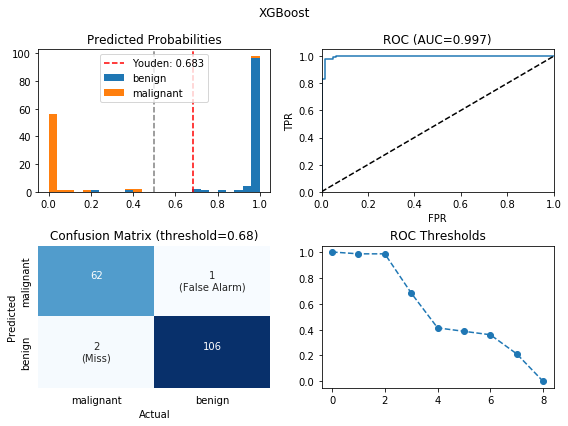

In [16]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=1000)

clf.fit(X_train, y_train)
y_hat = clf.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], 'XGBoost')

In [17]:
def plot_importances(booster, importance_type='gain', num_features=20, normalize=True):
    '''See https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score
       xgb_best.feature_importances_ returns normalized "gain"'''
    types = {'weight': 'Number of times used in splits',
             'gain'  : 'Average gain across all splits'}
    s_scores = pd.Series(booster.get_score(importance_type=importance_type))
    if normalize:
        s_scores = s_scores / s_scores.sum()
    s_scores.sort_values(ascending=False).head(n=num_features).plot.barh()
    if importance_type in types:
        plt.title(types[importance_type])
    else:
        plt.title(importance_type)
    plt.gca().invert_yaxis()

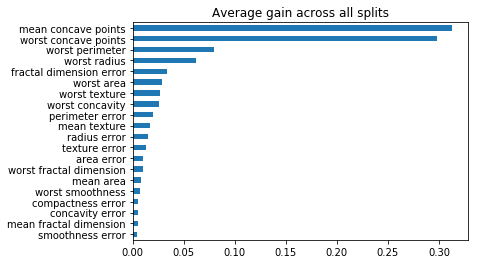

In [18]:
plot_importances(clf.get_booster(), 'gain')

from sklearn.metrics import roc_auc_score, confusion_matrix

for i in range(30):
    gs.best_estimator_.fit(X_train, y_train)
    y_hat = gs.best_estimator_.predict_proba(X_test)[:,1]
    print(roc_auc_score(y_test, y_hat))
    print(confusion_matrix(y_test, y_hat >= 0.5).ravel())